In [440]:
# !pip install yfinance matplotlib pandas scikit-learn keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf  

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM

## Pegando o histórico do Ethereum nos últimos 5 anos

In [441]:
tick = yf.Ticker('ETH-USD')
eth = tick.history(period='5y', interval='1d')
eth.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-08-17,287.683014,316.170013,287.346008,315.729004,1995460000,0,0
2018-08-18,316.790985,320.446014,286.550995,295.812012,1764020000,0,0
2018-08-19,295.670013,307.097992,291.332001,300.834015,1447910000,0,0
2018-08-20,301.381012,304.372009,273.510986,274.315002,1413790000,0,0
2018-08-21,273.330994,285.970001,273.330994,281.944000,1164120000,0,0


In [442]:
eth.index.min(), eth.index.max()

(Timestamp('2018-08-17 00:00:00'), Timestamp('2023-08-17 00:00:00'))

## Pegando o preço de fechamento e separando uma parte para treino e outra para teste

In [443]:
monthly_close =  eth['Close'].values.reshape(-1, 1)
monthly_close.shape

(1826, 1)

In [444]:
sep = int(len(monthly_close) * 0.7)  # 70% para treino e 30% para teste
train_data = monthly_close[:sep]
test_data = monthly_close[sep:]

## Após separados os dados de treino e teste, vamos normaliza-los para que o modelo não tenha problemas com a escala dos dados

In [445]:
train_scaler = MinMaxScaler()
test_scaler = MinMaxScaler()

In [446]:
train_scaled = train_scaler.fit_transform(train_data)
test_scaled = test_scaler.fit_transform(test_data)

## Após normalizados, vamos separar em X e y para treino e teste.

In [447]:
# intervalo no qual a rede vai usar como base para a projeção.
# nesse caso ela vai projetar usando os últimos 24 registros
period_train = 24

def prepare_data(data, period_train):
    X, y = [], []
    for i in range(len(data) - period_train):
        X.append(data[i:i + period_train])
        y.append(data[i + period_train])
    
    return np.array(X), np.array(y)

X_train, y_train = prepare_data(train_scaled, period_train)
X_test, y_test = prepare_data(test_scaled, period_train)

In [448]:
X_train.shape, y_train.shape

((1254, 24, 1), (1254, 1))

In [449]:
X_test.shape, y_test.shape

((524, 24, 1), (524, 1))

## Criando a estrutura da nossa rede neural recorrente

In [450]:
model = Sequential()

model.add(LSTM(units=40, input_shape=(period_train, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 40)                6720      
                                                                 
 dense_35 (Dense)            (None, 1)                 41        
                                                                 
Total params: 6761 (26.41 KB)
Trainable params: 6761 (26.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [451]:
model.fit(X_train, y_train, batch_size=1, epochs=1, verbose=2)

1254/1254 - 8s - loss: 0.0022 - 8s/epoch - 6ms/step


### Fazendo projeções com dados de teste

In [452]:
y_pred = model.predict(X_test)

17/17 [==============================] - 1s 4ms/step


### Restaurando os dados para a escala normal

In [453]:
y_test_restored = test_scaler.inverse_transform(y_test)
y_pred_restored = train_scaler.inverse_transform(y_pred)

### Visualizando graficamente

In [496]:
from datetime import datetime, timedelta
start_index = datetime.now() - timedelta(days=501)

labels = eth['Close'][start_index::100].index.astype(str).tolist()
xticks = list(range(0, X_test.shape[0] - period_train + 1, 100))

In [501]:
print(xticks, labels, sep='\n')

[0, 100, 200, 300, 400, 500]
['2022-04-03', '2022-07-12', '2022-10-20', '2023-01-28', '2023-05-08', '2023-08-17']


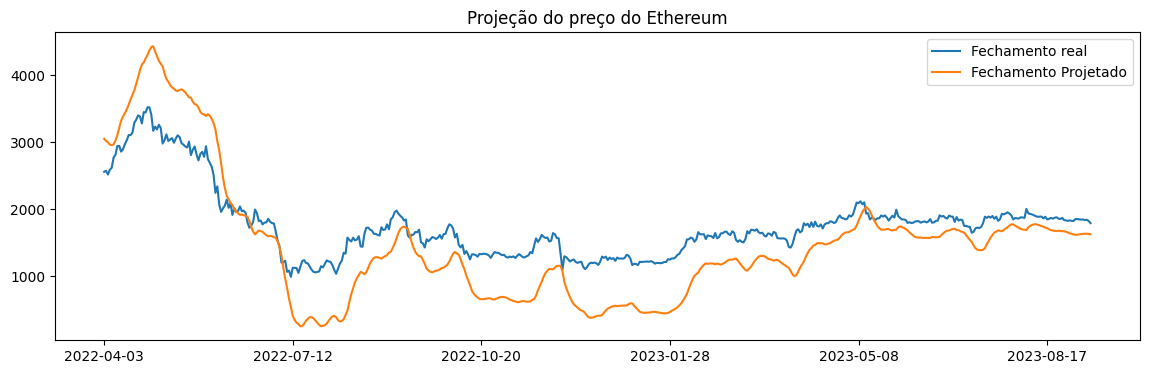

In [498]:
plt.figure(figsize=(14, 4))
plt.plot(y_test_restored, label='Fechamento real')
plt.plot(y_pred_restored, label='Fechamento Projetado')
plt.xticks(xticks, labels)
plt.legend()
plt.title('Projeção do preço do Ethereum')
plt.show()